In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

In [2]:
df = pd.read_excel('NASDAQ Realized Volatility.xlsx',index_col='Date',parse_dates=True)


Text(0, 0.5, 'Realized Volatility')

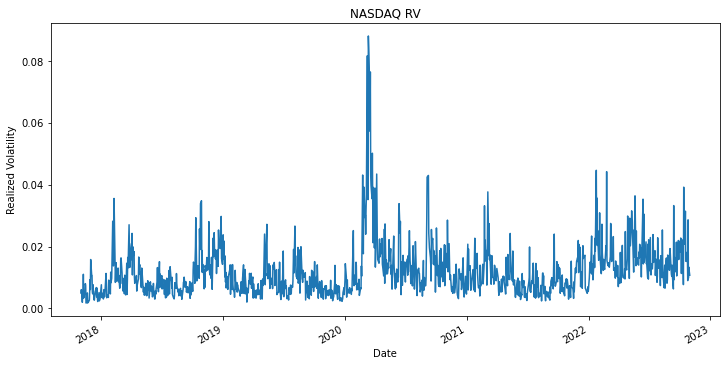

In [35]:
df["Realised"].plot(figsize=(12,6))
plt.title("NASDAQ RV")
plt.xlabel("Date")
plt.ylabel("Realized Volatility")

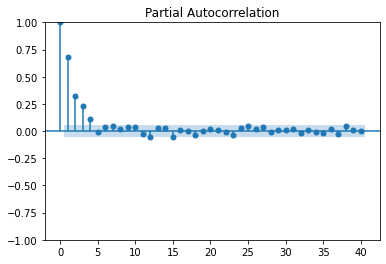

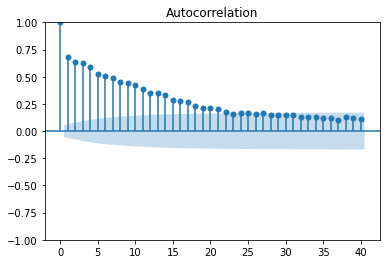

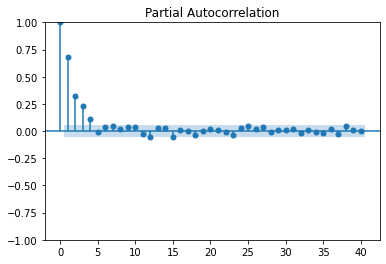

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(df["Realised"], lags = 40) 
plot_pacf(df["Realised"], lags = 40, method = "ols")

Augmented Dickey Fuller test

In [5]:
from statsmodels.tsa.stattools import adfuller
adfuller(df["Realised"])

(-6.748229042704257,
 2.9968898953699673e-09,
 3,
 1253,
 {'1%': -3.4355796466416777,
  '5%': -2.863849421064024,
  '10%': -2.5679995625056926},
 -9164.942189879623)

In [6]:
len(df["Realised"])


1257

Breusch Godfrey test

In [7]:
df_for_Breusch_Godfrey_test = df.reset_index(drop=True)

In [8]:
import statsmodels.api as sm
y = df_for_Breusch_Godfrey_test["Realised"]
x = df_for_Breusch_Godfrey_test[['Realised']][:1256]

In [9]:
for i in range(len(y)-1):
    y[i]=y[i+1]

C:\Users\GobatoH\AppData\Local\Temp\ipykernel_22164\3328281496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i]=y[i+1]


In [10]:
y=y[:1256]

In [11]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

In [12]:
import statsmodels.stats.diagnostic as dg

In [13]:
print(dg.acorr_breusch_godfrey(model, nlags=10))

(210.48520468341545, 1.0445658399403212e-39, 25.44843789665274, 2.8726558298493945e-44)


Ljung-Box Test

In [14]:
def sac(x, k=1):
    """
    Sample autocorrelation (As used in statistics with normalization)
    http://en.wikipedia.org/wiki/Autocorrelation
    Parameters
    ----------
    x : 1d numpy array
        Signal
    k : int or list of ints
        Lags to calculate sample autocorrelation for
    Returns
    -------
    res : scalar or np array
        The sample autocorrelation. A scalar value if k is a scalar, and a
        numpy array if k is a interable.
    """
    try:
        res = []
        for ki in k:
            res.append(sac(x, ki))
        return np.array(res)
    except:
        pass
    mx = np.mean(x)
    if k==0:
        N = np.sum((x-mx)*(x-mx))
    else:
        N = np.sum((x[:-k]-mx)*(x[k:]-mx))
    D = len(x) * np.var(x)
    return N/D


def ljungbox(x, lags, alpha=0.1):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2) / (n-k)
    Q = n*(n+2)*Q
    return Q

def boxpierce(x, lags, alpha=0.1):
    """
    The Box-Pierce test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2)
    Q = n*Q
    return Q

def lbqtest(x, lags, alpha=0.1, method='lb'):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : list of ints
        Lags being tested
    alpha : float
        Significance level used for the tests
    method : string
        Can be either 'lb' for Ljung-Box, or 'bp' for Box-Pierce
       
    Returns
    -------
    h : np array
        Numpy array of bool values, True == H0 hypothesis rejected
    pV : np array
        Test statistics p-values
    Q : np array
        Test statistics
    cV : np array
        Critical values used for determining if H0 should be rejected. The
        critical values are calculated from the given alpha and lag.
    """
    if method=='lb':
        findq = ljungbox
    else:
        findq = boxpierce
    n = len(x)
    Q = np.zeros(len(lags))
    pV = np.zeros(len(lags))
    cV = np.zeros(len(lags))
    for i, lag in enumerate(lags):
        Q[i] = findq(x, lag)
        pV[i] = 1.0 - scipy.stats.chi2.cdf(Q[i], lag)
        cV[i] = scipy.stats.chi2.ppf(1-alpha, lag)
    h = Q>cV
    return h, pV, Q, cV

In [15]:
h, pV, Q, cV = lbqtest(y, range(1, 20), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

lag   p-value          Q    c-value   rejectH0
1       0.000   1258.057      2.706      True
2       0.000   2514.433      4.605      True
3       0.000   3770.102      6.251      True
4       0.000   5017.406      7.779      True
5       0.000   6265.459      9.236      True
6       0.000   7511.765     10.645      True
7       0.000   8757.478     12.017      True
8       0.000  10001.961     13.362      True
9       0.000  11246.728     14.684      True
10      0.000  12481.863     15.987      True
11      0.000  13710.708     17.275      True
12      0.000  14935.823     18.549      True
13      0.000  16141.167     19.812      True
14      0.000  17344.331     21.064      True
15      0.000  18545.263     22.307      True
16      0.000  19744.877     23.542      True
17      0.000  20941.572     24.769      True
18      0.000  22139.042     25.989      True
19      0.000  23334.028     27.204      True


In [16]:
from pandas.plotting import lag_plot

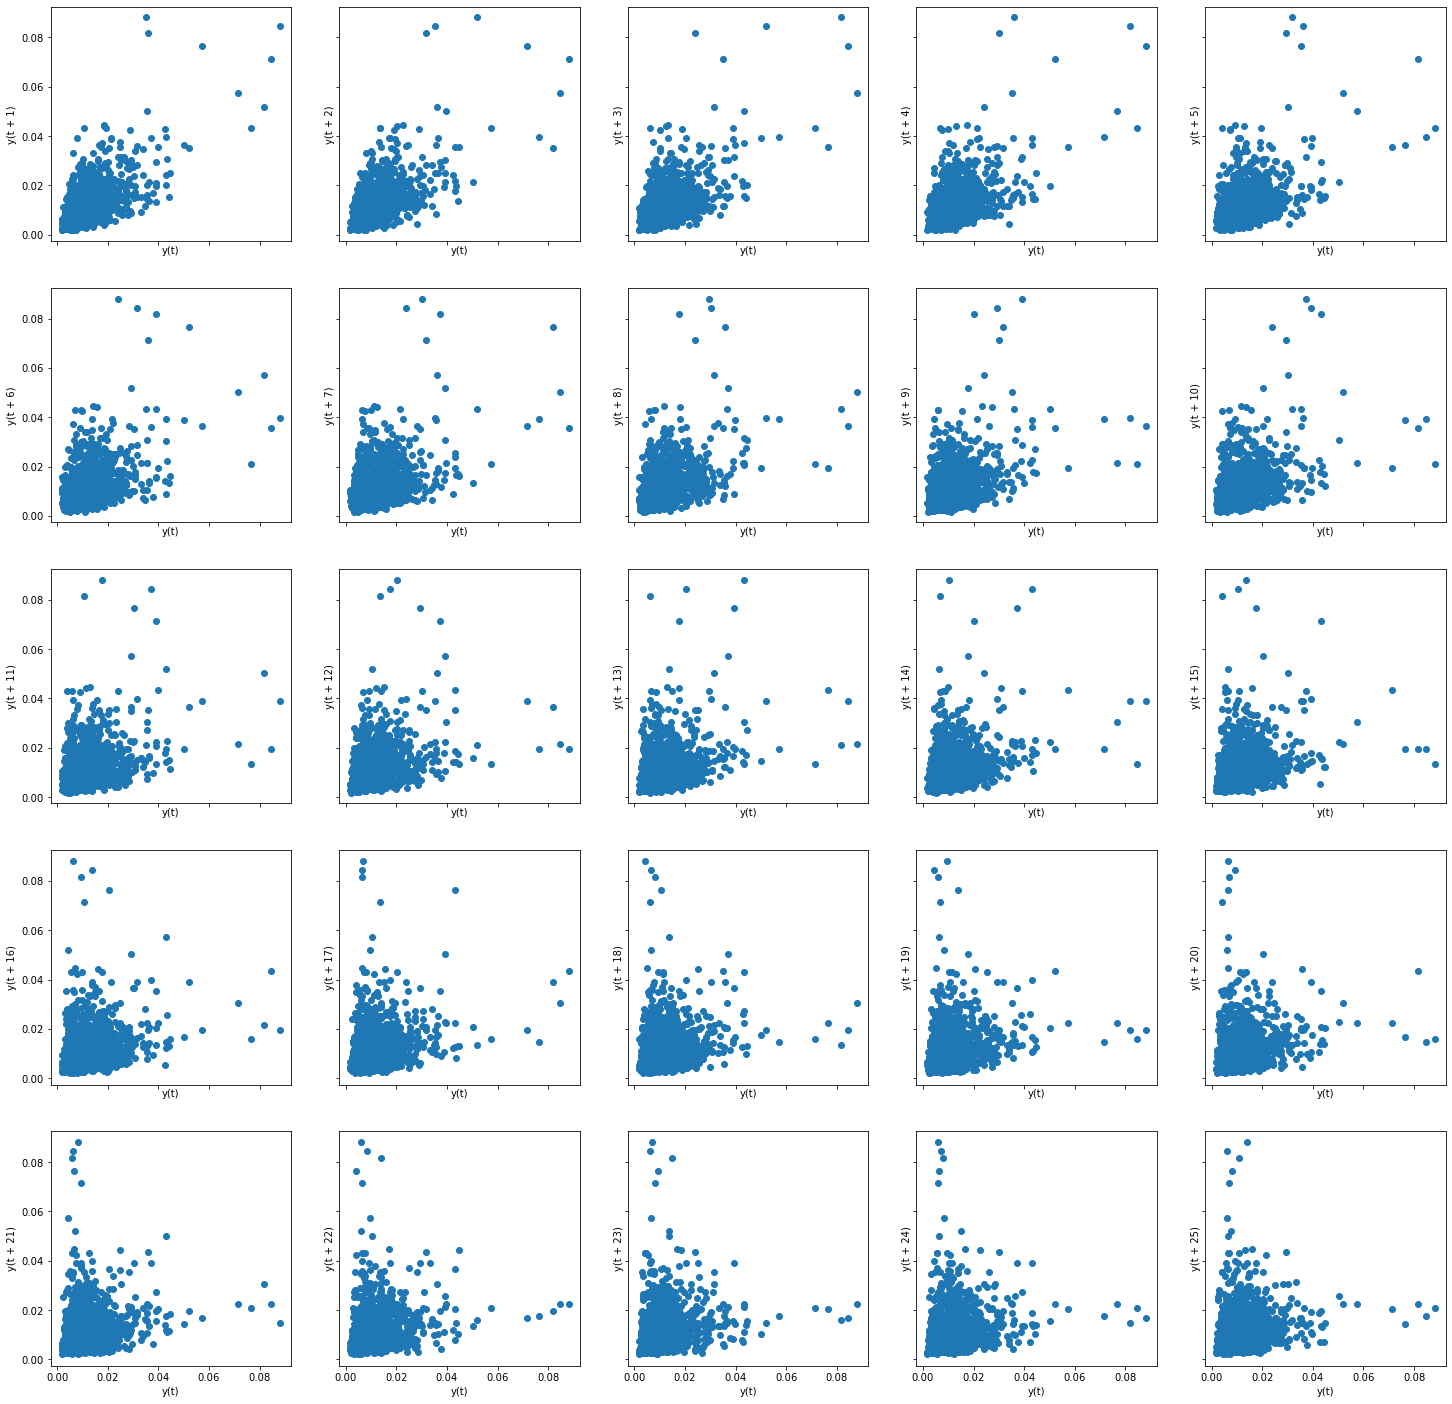

In [17]:
plot_lags = 25
rows = int(plot_lags/5)
cols = int(plot_lags/5)
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True)
fig.set_figwidth(plot_lags)
fig.set_figheight(plot_lags)
count =1
for i in range(rows):
    for j in range(cols):
        lag_plot(df["Realised"], lag=count, ax=axes[i, j])
        count+=1

Model Inputs Selection

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

In [4]:
n_inputs = [21,63,84,126,189,252]
n_neurons = [14,42,56,84,126,168]
RMSE = []
Accuracy = []
scaler = MinMaxScaler()

Determining the number of inputs

First trial (5 epochs)

In [20]:
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=5)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/5
884/884 [==============================] - 8s 7ms/step - loss: 0.0069
Epoch 2/5
884/884 [==============================] - 6s 7ms/step - loss: 0.0060
Epoch 3/5
884/884 [==============================] - 6s 7ms/step - loss: 0.0050
Epoch 4/5
884/884 [==============================] - 6s 7ms/step - loss: 0.0049
Epoch 5/5
1/1 [==============================] - 0s 22ms/step
Epoch 1/5
842/842 [==============================] - 16s 17ms/step - loss: 0.0074
Epoch 2/5
842/842 [==============================] - 16s 19ms/step - loss: 0.1100
Epoch 3/5
842/842 [==============================] - 23s 27ms/step - loss: 0.0057
Epoch 4/5
842/842 [==============================] - 15s 18ms/step - loss: 0.0049
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 1/5
821/821 [==============================] - 22s 25ms/step - loss: 0.0068
Epoch 2/5
821/821 [==============================] - 22s 27ms/step - loss: 0.0054
Epoch 3/5
821/821 [==============================] - 19s 23ms/step - loss: 0.0053
Epoch 4/5
821/821 [==============================] - 19s 23ms/step - loss: 0.0051
Epoch 5/5
1/1 [==============================] - 0s 22ms/step
Epoch 1/5
779/779 [==============================] - 37s 46ms/step - loss: 0.0073
Epoch 2/5
779/779 [==============================] - 29s 37ms/step - loss: nan
Epoch 3/5
779/779 [==============================] - 28s 36ms/step - loss: nan
Epoch 4/5
779/779 [==============================] - 28s 36ms/step - loss: nan
Epoch 5/5
1/1 [==============================] - 0s 29ms/step
Epoch 1/5
716/716 [==============================] - 47s 63ms/step - loss: 0.0074
Epoch 2/5
716/716 [==============================] - 47s 66ms/step - loss: 0.0064
Epoch 3/5
716

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
653/653 [==============================] - 63s 94ms/step - loss: 0.0080
Epoch 2/5
653/653 [==============================] - 65s 100ms/step - loss: 0.0062
Epoch 3/5
653/653 [==============================] - 63s 97ms/step - loss: 0.0063
Epoch 4/5
653/653 [==============================] - 65s 99ms/step - loss: 0.0057
Epoch 5/5
1/1 [==============================] - 0s 41ms/step


In [25]:
RMSE

[0.0010645968967601593,
 0.0011251739219403046,
 0.0010432010478915444,
 0.0,
 0.0019140787178538055,
 0.0010567834369455628]

In [22]:
Accuracy

[54.67274266471196,
 49.39317322786078,
 56.73669881632244,
 100.0,
 6.5808247306301855,
 56.010508262485004]

Second trial (10 epochs)

In [26]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=10)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/10
884/884 [==============================] - 10s 9ms/step - loss: 0.0075
Epoch 2/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0058
Epoch 3/10
884/884 [==============================] - 8s 9ms/step - loss: 0.0049
Epoch 4/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0048
Epoch 5/10
884/884 [==============================] - 11s 13ms/step - loss: 0.0047
Epoch 6/10
884/884 [==============================] - 12s 13ms/step - loss: 0.0045
Epoch 7/10
884/884 [==============================] - 8s 9ms/step - loss: 0.0047
Epoch 8/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0046
Epoch 9/10
884/884 [==============================] - 8s 8ms/step - loss: 0.0045
Epoch 10/10
1/1 [==============================] - 0s 23ms/step
Epoch 1/10
842/842 [==============================] - 20s 21ms/step - loss: 0.0071
Epoch 2/10
842/842 [==============================] - 15s 17ms/step - loss: 0.0055
Epoch 3/10
842/842 [=============

1/1 [==============================] - 0s 31ms/step
Epoch 1/10
779/779 [==============================] - 44s 53ms/step - loss: 0.0067
Epoch 2/10
779/779 [==============================] - 37s 47ms/step - loss: 0.0059
Epoch 3/10
779/779 [==============================] - 33s 42ms/step - loss: 0.0052
Epoch 4/10
779/779 [==============================] - 36s 46ms/step - loss: 0.0069
Epoch 5/10
779/779 [==============================] - 33s 43ms/step - loss: 0.0054
Epoch 6/10
779/779 [==============================] - 39s 50ms/step - loss: 0.0050
Epoch 7/10
779/779 [==============================] - 34s 44ms/step - loss: 16878284.0000
Epoch 8/10
779/779 [==============================] - 35s 45ms/step - loss: 0.0051
Epoch 9/10
779/779 [==============================] - 33s 42ms/step - loss: 0.0051
Epoch 10/10
1/1 [==============================] - 0s 45ms/step
Epoch 1/10
716/716 [==============================] - 57s 75ms/step - loss: 0.0085
Epoch 2/10
716/716 [===========================

1/1 [==============================] - 0s 49ms/step


In [27]:
RMSE

[0.003088624661991038,
 0.0028523562504669943,
 0.0025786244661236187,
 0.0028780099414529798,
 0.002520422193934811,
 0.0]

In [28]:
Accuracy

[43.274580018414056,
 49.541336382374936,
 59.74878817626814,
 48.50728193616223,
 61.287582116370196,
 100.0]

Third trial (15 epochs)

In [29]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=15)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/15
884/884 [==============================] - 9s 8ms/step - loss: 0.0074
Epoch 2/15
884/884 [==============================] - 8s 9ms/step - loss: 0.0061
Epoch 3/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0054
Epoch 4/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0047
Epoch 5/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0050
Epoch 6/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0048
Epoch 7/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0047
Epoch 8/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0046
Epoch 9/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0046
Epoch 10/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0047
Epoch 11/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0045
Epoch 12/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0045
Epoch 13/15
884/884 [====

1/1 [==============================] - 0s 29ms/step
Epoch 1/15
821/821 [==============================] - 29s 32ms/step - loss: 0.0071
Epoch 2/15
821/821 [==============================] - 26s 32ms/step - loss: 0.0057
Epoch 3/15
821/821 [==============================] - 30s 36ms/step - loss: 0.0053
Epoch 4/15
821/821 [==============================] - 30s 36ms/step - loss: 0.0049
Epoch 5/15
821/821 [==============================] - 30s 36ms/step - loss: 0.0049
Epoch 6/15
821/821 [==============================] - 30s 36ms/step - loss: 0.0050
Epoch 7/15
821/821 [==============================] - 29s 35ms/step - loss: 0.0049
Epoch 8/15
821/821 [==============================] - 27s 33ms/step - loss: 0.0048
Epoch 9/15
821/821 [==============================] - 28s 35ms/step - loss: 0.0048
Epoch 10/15
821/821 [==============================] - 29s 35ms/step - loss: 0.0046
Epoch 11/15
821/821 [==============================] - 29s 35ms/step - loss: 0.0047
Epoch 12/15
821/821 [============

1/1 [==============================] - 0s 38ms/step
Epoch 1/15
716/716 [==============================] - 58s 78ms/step - loss: 0.0069
Epoch 2/15
716/716 [==============================] - 57s 80ms/step - loss: 0.0062
Epoch 3/15
716/716 [==============================] - 57s 79ms/step - loss: 0.0061
Epoch 4/15
716/716 [==============================] - 58s 80ms/step - loss: 0.0055
Epoch 5/15
716/716 [==============================] - 57s 80ms/step - loss: 0.0054
Epoch 6/15
716/716 [==============================] - 58s 81ms/step - loss: 0.0054
Epoch 7/15
716/716 [==============================] - 58s 81ms/step - loss: nan
Epoch 8/15
716/716 [==============================] - 58s 81ms/step - loss: nan
Epoch 9/15
716/716 [==============================] - 59s 82ms/step - loss: nan
Epoch 10/15
716/716 [==============================] - 59s 82ms/step - loss: nan
Epoch 11/15
716/716 [==============================] - 58s 81ms/step - loss: nan
Epoch 12/15
716/716 [===========================

In [30]:
RMSE

[0.0028559840659196766,
 0.004144987560991887,
 0.002900646037598677,
 0.0028122548028975797,
 0.0,
 0.0]

In [31]:
Accuracy

[50.00498170036125,
 21.87883157410232,
 49.084472595764296,
 51.06656713859265,
 100.0,
 100.0]

10 epochs were chosen

Fourth trial

In [5]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=10)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/10
884/884 [==============================] - 10s 9ms/step - loss: 0.0059
Epoch 2/10
884/884 [==============================] - 8s 10ms/step - loss: 0.0053
Epoch 3/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0049
Epoch 4/10
884/884 [==============================] - 8s 10ms/step - loss: 0.0049
Epoch 5/10
884/884 [==============================] - 8s 9ms/step - loss: 0.0050
Epoch 6/10
884/884 [==============================] - 8s 9ms/step - loss: 0.0046
Epoch 7/10
884/884 [==============================] - 8s 9ms/step - loss: 0.0047
Epoch 8/10
884/884 [==============================] - 8s 9ms/step - loss: 0.0045
Epoch 9/10
884/884 [==============================] - 8s 9ms/step - loss: 0.0046
Epoch 10/10
1/1 [==============================] - 0s 29ms/step
Epoch 1/10
842/842 [==============================] - 23s 25ms/step - loss: 0.0064
Epoch 2/10
842/842 [==============================] - 21s 25ms/step - loss: 0.0054
Epoch 3/10
842/842 [=================

1/1 [==============================] - 0s 37ms/step
Epoch 1/10
779/779 [==============================] - 43s 52ms/step - loss: 0.0071
Epoch 2/10
779/779 [==============================] - 41s 52ms/step - loss: 0.0060
Epoch 3/10
779/779 [==============================] - 41s 52ms/step - loss: 0.0053
Epoch 4/10
779/779 [==============================] - 41s 52ms/step - loss: 0.0053
Epoch 5/10
779/779 [==============================] - 42s 54ms/step - loss: 0.0051
Epoch 6/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0049
Epoch 7/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0048
Epoch 8/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0049
Epoch 9/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0046
Epoch 10/10
1/1 [==============================] - 0s 40ms/step
Epoch 1/10
716/716 [==============================] - 59s 80ms/step - loss: 0.0077
Epoch 2/10
716/716 [==============================] - 

1/1 [==============================] - 0s 58ms/step


In [7]:
RMSE

[0.0009996451786696218,
 0.0013317966488084144,
 0.0010726424286416655,
 0.0014148439369272366,
 0.0012309421135580751,
 0.0011876199313571555]

In [7]:
Accuracy

[61.445728140145775,
 37.201076715195406,
 54.340189073951414,
 32.53315853135926,
 42.953058781211496,
 45.75231879413204]

Fifth trial

In [8]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=10)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/10
884/884 [==============================] - 16s 12ms/step - loss: 0.0087
Epoch 2/10
884/884 [==============================] - 11s 13ms/step - loss: 0.0057
Epoch 3/10
884/884 [==============================] - 12s 14ms/step - loss: 0.0054
Epoch 4/10
884/884 [==============================] - 13s 15ms/step - loss: 0.0050
Epoch 5/10
884/884 [==============================] - 13s 15ms/step - loss: 0.0049
Epoch 6/10
884/884 [==============================] - 12s 14ms/step - loss: 0.0048
Epoch 7/10
884/884 [==============================] - 12s 13ms/step - loss: 0.0047
Epoch 8/10
884/884 [==============================] - 12s 14ms/step - loss: 0.0047
Epoch 9/10
884/884 [==============================] - 12s 14ms/step - loss: 0.0046
Epoch 10/10
1/1 [==============================] - 0s 44ms/step
Epoch 1/10
842/842 [==============================] - 32s 33ms/step - loss: 0.0068
Epoch 2/10
842/842 [==============================] - 28s 33ms/step - loss: 0.0064
Epoch 3/10
842/842 [===

1/1 [==============================] - 0s 36ms/step
Epoch 1/10
779/779 [==============================] - 42s 50ms/step - loss: 0.0075
Epoch 2/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0061
Epoch 3/10
779/779 [==============================] - 41s 52ms/step - loss: 0.0056
Epoch 4/10
779/779 [==============================] - 42s 53ms/step - loss: 0.0051
Epoch 5/10
779/779 [==============================] - 41s 52ms/step - loss: 0.0052
Epoch 6/10
779/779 [==============================] - 41s 52ms/step - loss: 0.0050
Epoch 7/10
779/779 [==============================] - 42s 53ms/step - loss: 0.0051
Epoch 8/10
779/779 [==============================] - 42s 53ms/step - loss: 0.0048
Epoch 9/10
779/779 [==============================] - 42s 54ms/step - loss: 0.0049
Epoch 10/10
1/1 [==============================] - 0s 69ms/step
Epoch 1/10
716/716 [==============================] - 80s 105ms/step - loss: 0.0079
Epoch 2/10
716/716 [==============================] -

1/1 [==============================] - 0s 38ms/step


In [9]:
RMSE

[0.0028445529727369207,
 0.0027438215065269033,
 0.002706072294576169,
 0.0033058612019974815,
 0.002679643675862336,
 0.0028017668465851716]

In [10]:
Accuracy

[50.03998270033978,
 53.24295807108277,
 54.755772055950594,
 38.54187368714172,
 56.428944427377495,
 50.86106240049393]

Sixth trial

In [11]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=10)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/10
884/884 [==============================] - 7s 6ms/step - loss: 0.0075
Epoch 2/10
884/884 [==============================] - 5s 6ms/step - loss: 0.0059
Epoch 3/10
884/884 [==============================] - 5s 6ms/step - loss: 0.0051
Epoch 4/10
884/884 [==============================] - 5s 6ms/step - loss: 0.0046
Epoch 5/10
884/884 [==============================] - 5s 6ms/step - loss: 0.0047
Epoch 6/10
884/884 [==============================] - 5s 6ms/step - loss: 0.0045
Epoch 7/10
884/884 [==============================] - 6s 7ms/step - loss: 0.0045
Epoch 8/10
884/884 [==============================] - 6s 6ms/step - loss: 0.0046
Epoch 9/10
884/884 [==============================] - 5s 6ms/step - loss: 0.0044
Epoch 10/10
1/1 [==============================] - 0s 20ms/step
Epoch 1/10
842/842 [==============================] - 14s 14ms/step - loss: 0.0069
Epoch 2/10
842/842 [==============================] - 12s 14ms/step - loss: 0.0058
Epoch 3/10
842/842 [=====================

1/1 [==============================] - 0s 21ms/step
Epoch 1/10
821/821 [==============================] - 16s 17ms/step - loss: 0.0067
Epoch 2/10
821/821 [==============================] - 15s 18ms/step - loss: 0.0057
Epoch 3/10
821/821 [==============================] - 15s 18ms/step - loss: 0.0053
Epoch 4/10
821/821 [==============================] - 15s 18ms/step - loss: 0.0054
Epoch 5/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0048
Epoch 6/10
821/821 [==============================] - 20s 24ms/step - loss: 0.0049
Epoch 7/10
821/821 [==============================] - 18s 22ms/step - loss: 0.0050
Epoch 8/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0047
Epoch 9/10
821/821 [==============================] - 20s 25ms/step - loss: 0.0048
Epoch 10/10
1/1 [==============================] - 0s 36ms/step
Epoch 1/10
779/779 [==============================] - 40s 48ms/step - loss: 0.0078
Epoch 2/10
779/779 [==============================] - 

716/716 [==============================] - 50s 70ms/step - loss: 0.0056
Epoch 7/10
716/716 [==============================] - 50s 71ms/step - loss: 0.0055
Epoch 8/10
716/716 [==============================] - 51s 71ms/step - loss: 0.0053
Epoch 9/10
716/716 [==============================] - 46s 64ms/step - loss: 0.0052
Epoch 10/10
1/1 [==============================] - 0s 50ms/step
Epoch 1/10
653/653 [==============================] - 64s 95ms/step - loss: 0.0074
Epoch 2/10
653/653 [==============================] - 65s 99ms/step - loss: 0.0066
Epoch 3/10
653/653 [==============================] - 72s 111ms/step - loss: 0.0059
Epoch 4/10
653/653 [==============================] - 61s 93ms/step - loss: 0.0059
Epoch 5/10
653/653 [==============================] - 70s 107ms/step - loss: 21659124.0000
Epoch 6/10
653/653 [==============================] - 66s 100ms/step - loss: 0.0060
Epoch 7/10
653/653 [==============================] - 65s 100ms/step - loss: 0.0054
Epoch 8/10
653/653 [===

In [12]:
RMSE

[0.0027887586588072407,
 0.0030885985077728174,
 0.002687717004874204,
 0.0031657619304585115,
 0.0027761028131987092,
 0.00286710664952541]

In [13]:
Accuracy

[51.49089546607952,
 42.823613366772825,
 55.53589137923167,
 40.8949153169994,
 51.462274198568494,
 49.021657177521746]

Seventh trial

In [5]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=10)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/10
884/884 [==============================] - 15s 12ms/step - loss: 0.0069
Epoch 2/10
884/884 [==============================] - 10s 12ms/step - loss: 0.0056
Epoch 3/10
884/884 [==============================] - 11s 12ms/step - loss: 0.0050
Epoch 4/10
884/884 [==============================] - 11s 12ms/step - loss: 0.0048
Epoch 5/10
884/884 [==============================] - 10s 12ms/step - loss: 0.0049
Epoch 6/10
884/884 [==============================] - 11s 12ms/step - loss: 0.0048
Epoch 7/10
884/884 [==============================] - 12s 13ms/step - loss: 0.0047
Epoch 8/10
884/884 [==============================] - 10s 12ms/step - loss: 0.0046
Epoch 9/10
884/884 [==============================] - 10s 11ms/step - loss: 0.0046
Epoch 10/10
1/1 [==============================] - 0s 37ms/step
Epoch 1/10
842/842 [==============================] - 30s 30ms/step - loss: 0.0062
Epoch 2/10
842/842 [==============================] - 24s 28ms/step - loss: 0.0079
Epoch 3/10
842/842 [===

1/1 [==============================] - 0s 43ms/step
Epoch 1/10
821/821 [==============================] - 30s 33ms/step - loss: 0.0067
Epoch 2/10
821/821 [==============================] - 27s 33ms/step - loss: 0.0054
Epoch 3/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0052
Epoch 4/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0051
Epoch 5/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0049
Epoch 6/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0047
Epoch 7/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0049
Epoch 8/10
821/821 [==============================] - 33s 40ms/step - loss: 0.0048
Epoch 9/10
821/821 [==============================] - 30s 36ms/step - loss: 0.0047
Epoch 10/10
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step
Epoch 1/10
779/779 [==============================] - 42s 52ms/step - loss: 0.0064
Epoch 2/10
779/779 [==============================] - 40s 52ms/step - loss: 0.0056
Epoch 3/10
779/779 [==============================] - 41s 52ms/step - loss: 0.0054
Epoch 4/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0050
Epoch 5/10
779/779 [==============================] - 41s 53ms/step - loss: 2.5114
Epoch 6/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0051
Epoch 7/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0045
Epoch 8/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0044
Epoch 9/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0045
Epoch 10/10
1/1 [==============================] - 0s 38ms/step
Epoch 1/10
716/716 [==============================] - 60s 81ms/step - loss: 0.0080
Epoch 2/10
716/716 [==============================] - 

716/716 [==============================] - 57s 80ms/step - loss: 0.0055
Epoch 6/10
716/716 [==============================] - 57s 79ms/step - loss: 0.0052
Epoch 7/10
716/716 [==============================] - 57s 80ms/step - loss: 0.0051
Epoch 8/10
716/716 [==============================] - 57s 80ms/step - loss: 0.0051
Epoch 9/10
716/716 [==============================] - 57s 80ms/step - loss: 0.0052
Epoch 10/10
1/1 [==============================] - 0s 49ms/step
Epoch 1/10
653/653 [==============================] - 69s 103ms/step - loss: 0.0082
Epoch 2/10
653/653 [==============================] - 72s 110ms/step - loss: nan
Epoch 3/10
653/653 [==============================] - 70s 108ms/step - loss: nan
Epoch 4/10
 93/653 [===>..........................] - ETA: 1:01 - loss: nan

KeyboardInterrupt: 

In [6]:
RMSE

[0.002878789628017198,
 0.0031230896567265363,
 0.002749914088720687,
 0.003131220345511589,
 0.002780748904707737]

In [7]:
Accuracy

[49.38098198498423,
 42.6231155094366,
 52.744903758931336,
 42.8400768457291,
 51.810094208621635]

Eighth trial

In [8]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=10)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/10
884/884 [==============================] - 12s 10ms/step - loss: 0.0107
Epoch 2/10
884/884 [==============================] - 9s 11ms/step - loss: 0.0060
Epoch 3/10
884/884 [==============================] - 8s 10ms/step - loss: 0.0053
Epoch 4/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0050
Epoch 5/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0050
Epoch 6/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0048
Epoch 7/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0047
Epoch 8/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0047
Epoch 9/10
884/884 [==============================] - 9s 10ms/step - loss: 0.0046
Epoch 10/10
1/1 [==============================] - 0s 28ms/step
Epoch 1/10
842/842 [==============================] - 23s 25ms/step - loss: 0.0075
Epoch 2/10
842/842 [==============================] - 21s 25ms/step - loss: 0.0062
Epoch 3/10
842/842 [===========

1/1 [==============================] - 0s 31ms/step
Epoch 1/10
821/821 [==============================] - 30s 34ms/step - loss: 0.0081
Epoch 2/10
821/821 [==============================] - 28s 33ms/step - loss: 0.0056
Epoch 3/10
821/821 [==============================] - 27s 33ms/step - loss: 546060096.0000
Epoch 4/10
821/821 [==============================] - 27s 33ms/step - loss: 0.0056
Epoch 5/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0052
Epoch 6/10
821/821 [==============================] - 29s 35ms/step - loss: 0.0050
Epoch 7/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0048
Epoch 8/10
821/821 [==============================] - 28s 34ms/step - loss: 0.0047
Epoch 9/10
821/821 [==============================] - 29s 35ms/step - loss: 0.0046
Epoch 10/10
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 33ms/step
Epoch 1/10
779/779 [==============================] - 43s 53ms/step - loss: 0.0079
Epoch 2/10
779/779 [==============================] - 41s 52ms/step - loss: 0.0067
Epoch 3/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0057
Epoch 4/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0055
Epoch 5/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0051
Epoch 6/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0048
Epoch 7/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0050
Epoch 8/10
779/779 [==============================] - 41s 53ms/step - loss: 0.0050
Epoch 9/10
779/779 [==============================] - 42s 54ms/step - loss: 0.0050
Epoch 10/10
1/1 [==============================] - 0s 41ms/step
Epoch 1/10
716/716 [==============================] - 62s 84ms/step - loss: 0.0081
Epoch 2/10
716/716 [==============================] - 

716/716 [==============================] - 58s 81ms/step - loss: 0.0056
Epoch 6/10
716/716 [==============================] - 58s 81ms/step - loss: 0.0054
Epoch 7/10
716/716 [==============================] - 58s 81ms/step - loss: nan
Epoch 8/10
716/716 [==============================] - 58s 82ms/step - loss: nan
Epoch 9/10
716/716 [==============================] - 59s 82ms/step - loss: nan
Epoch 10/10
1/1 [==============================] - 0s 50ms/step
Epoch 1/10
653/653 [==============================] - 71s 105ms/step - loss: 0.0088
Epoch 2/10
653/653 [==============================] - 70s 108ms/step - loss: 0.0072
Epoch 3/10
653/653 [==============================] - 73s 111ms/step - loss: 0.0063
Epoch 4/10
653/653 [==============================] - 74s 113ms/step - loss: 3198.2598
Epoch 5/10
653/653 [==============================] - 49s 75ms/step - loss: 0.0060
Epoch 6/10
653/653 [==============================] - 48s 73ms/step - loss: nan
Epoch 7/10
653/653 [===================

KeyboardInterrupt: 

In [9]:
RMSE

[0.0031748971352493676,
 0.002642073601937822,
 0.0027996750905530505,
 0.0033181748798152212,
 0.0]

In [10]:
Accuracy

[40.99462078706711,
 56.5606844212452,
 51.521302094694256,
 37.840340262834246,
 100.0]

In [12]:
# n_inputs = [21,63,84,126,189,252]
RMSE_average_validation_with_21inputs = (0.0031748971352493676+
                                        0.002878789628017198+0.0027887586588072407
                                        +0.0028445529727369207+0.0009996451786696218+
                                        0.003088624661991038)/6
print(RMSE_average_validation_with_21inputs)

0.002629211372578564


In [13]:
RMSE_average_validation_with_63inputs = (0.002642073601937822
                                         +0.0031230896567265363+0.0030885985077728174
                                        +0.0027438215065269033+0.0013317966488084144+0.0028523562504669943)/6
print(RMSE_average_validation_with_63inputs)

0.0026302893620399146


In [14]:
RMSE_average_validation_with_84inputs = (0.0027996750905530505+0.002749914088720687
                                        +0.002687717004874204+0.002706072294576169+
                                        0.0010726424286416655+0.0025786244661236187)/6
print(RMSE_average_validation_with_84inputs)

0.002432440895581566


In [15]:
RMSE_average_validation_with_126inputs = (0.0033181748798152212+0.003131220345511589
                                         +0.0031657619304585115+0.0033058612019974815+
                                         0.0014148439369272366+0.0028780099414529798)/6
print(RMSE_average_validation_with_126inputs)

0.0028689787060271698


189 and 252 had multiple errors, hence their use is presumably not optimal for this problem

Given the results above, "84 inputs" was chosen

In [16]:
RMSE = []
Accuracy = []

In [32]:
for i in range (7):
    train = df.iloc[:1005]
    test = df.iloc[1005:]
    scaler.fit(train)
    scaled_train_input = scaler.transform(train)
    scaled_test_input = scaler.transform(test)
    train = df["Realised"].iloc[:1005]
    test = df["Realised"].iloc[1005:]
    train = train.array.reshape(-1, 1)
    test = test.array.reshape(-1, 1)
    scaler.fit(train)
    scaled_train_target = scaler.transform(train)
    scaled_test_target = scaler.transform(test)
    n_features = 4
    n_input = n_inputs[2]
    generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
    model = Sequential()
    model.add(LSTM(n_neurons[2], activation='relu', input_shape=(n_input, n_features)))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
    model.fit(generator,epochs=10)
    last_train_batch = scaled_train_input[-n_input:]
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
    a = np.array(scaled_test_input)
    test_predictions = []
    first_eval_batch = scaled_train_input[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
    for j in range(len(test)):
            # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
        test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
    true_predictions = scaler.inverse_transform(test_predictions)
    RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
    Accuracy.append((1-(np.sum(np.sqrt((test-true_predictions)**2)/test)/len(test)))*100)

Epoch 1/10
921/921 [==============================] - 19s 19ms/step - loss: 0.0076 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0562
Epoch 2/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0487
Epoch 3/10
921/921 [==============================] - 22s 23ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0490
Epoch 4/10
921/921 [==============================] - 25s 27ms/step - loss: 0.0055 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0491
Epoch 5/10
921/921 [==============================] - 22s 23ms/step - loss: 0.0051 - accuracy: 0.0011 - mean_absolute_error: 0.0473
Epoch 6/10
921/921 [==============================] - 20s 22ms/step - loss: 0.0057 - accuracy: 0.0011 - mean_absolute_error: 0.0482
Epoch 7/10
921/921 [==============================] - 22s 23ms/step - loss: 0.0051 - accuracy: 0.0011 - mean_absolute_error: 0.0470
Epoch 8/10
921/921 [==============================] - 25s 27

1/1 [==============================] - 0s 69ms/step
Epoch 1/10
921/921 [==============================] - 26s 25ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0569
Epoch 2/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0062 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0511
Epoch 3/10
921/921 [==============================] - 25s 27ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0497
Epoch 4/10
921/921 [==============================] - 23s 25ms/step - loss: 0.0051 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0480
Epoch 5/10
921/921 [==============================] - 20s 21ms/step - loss: 0.0062 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0499
Epoch 6/10
921/921 [==============================] - 22s 24ms/step - loss: 0.0051 - accuracy: 0.0011 - mean_absolute_error: 0.0478
Epoch 7/10
921/921 [==============================] - 20s 22ms/step - loss: 0.0053 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0474


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 1/10
921/921 [==============================] - 24s 23ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0550
Epoch 2/10
921/921 [==============================] - 19s 21ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0505
Epoch 3/10
921/921 [==============================] - 20s 22ms/step - loss: 0.0054 - accuracy: 0.0011 - mean_absolute_error: 0.0490
Epoch 4/10
921/921 [==============================] - 19s 21ms/step - loss: 0.0051 - accuracy: 0.0011 - mean_absolute_error: 0.0479
Epoch 5/10
921/921 [==============================] - 22s 23ms/step - loss: 0.0055 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0474
Epoch 6/10
921/921 [==============================] - 20s 22ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0485
Epoch 7/10
921/921 [==============================] - 22s 24ms/step - loss: 0.0056 - accuracy: 0.0011 - mean_absolute_error: 0.0489
Epoch 8/

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 35ms/step
Epoch 1/10
921/921 [==============================] - 27s 27ms/step - loss: 0.0081 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0562
Epoch 2/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0056 - accuracy: 0.0011 - mean_absolute_error: 0.0496
Epoch 3/10
921/921 [==============================] - 25s 27ms/step - loss: 0.0055 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0487
Epoch 4/10
921/921 [==============================] - 27s 30ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0491
Epoch 5/10
921/921 [==============================] - 23s 25ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0493
Epoch 6/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0055 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0473
Epoch 7/10
921/921 [==============================] - 22s 23ms/step - loss: 0.0051 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0465


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 1/10
921/921 [==============================] - 22s 22ms/step - loss: 0.0078 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0552
Epoch 2/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0511
Epoch 3/10
921/921 [==============================] - 19s 21ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0497
Epoch 4/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0484
Epoch 5/10
921/921 [==============================] - 20s 21ms/step - loss: 0.0052 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0471
Epoch 6/10
921/921 [==============================] - 20s 21ms/step - loss: 0.0055 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0486
Epoch 7/10
921/921 [==============================] - 20s 22ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0

1/1 [==============================] - 0s 47ms/step
Epoch 1/10
921/921 [==============================] - 47s 48ms/step - loss: 0.0088 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0584
Epoch 2/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0065 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0521
Epoch 3/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0495
Epoch 4/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0501
Epoch 5/10
921/921 [==============================] - 22s 24ms/step - loss: 0.0050 - accuracy: 0.0011 - mean_absolute_error: 0.0478
Epoch 6/10
921/921 [==============================] - 18s 20ms/step - loss: 0.0062 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0507
Epoch 7/10
921/921 [==============================] - 17s 18ms/step - loss: 0.0055 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0493


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Epoch 1/10
921/921 [==============================] - 19s 18ms/step - loss: 0.0074 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0545
Epoch 2/10
921/921 [==============================] - 22s 24ms/step - loss: 0.0061 - accuracy: 0.0011 - mean_absolute_error: 0.0495
Epoch 3/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0052 - accuracy: 0.0011 - mean_absolute_error: 0.0478
Epoch 4/10
921/921 [==============================] - 21s 23ms/step - loss: 0.0055 - accuracy: 0.0011 - mean_absolute_error: 0.0483
Epoch 5/10
921/921 [==============================] - 25s 27ms/step - loss: 10786637.0000 - accuracy: 0.0011 - mean_absolute_error: 147.0278
Epoch 6/10
921/921 [==============================] - 21s 22ms/step - loss: 0.0066 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0555
Epoch 7/10
921/921 [==============================] - 21s 22ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0539
Epo

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


In [37]:
Accuracy

[70.39811905592103,
 68.76122773696463,
 70.74890067184081,
 67.67561234298762,
 70.94421816745337,
 70.4086564005799,
 70.44992577597952,
 70.27747361257192,
 70.10035399626022,
 70.56842765246289,
 65.21466498668217,
 70.32047675765523,
 70.15189305151021,
 65.08105214024204,
 69.26387258191701]

In [38]:
print("mean: %s" %(round(np.mean(Accuracy),2))+"%")

mean: 69.36%


In [39]:
print("stdv: %s" %(round(np.std(Accuracy),2))+"%")

stdv: 1.84%


In [40]:
Accuracy_CI_95_lower_bound=np.mean(Accuracy)-2*np.std(Accuracy)
Accuracy_CI_95_upper_bound=np.mean(Accuracy)+2*np.std(Accuracy)
print("95 percent CI lower bound: %s" %round(Accuracy_CI_95_lower_bound,2)+"%")
print("95 percent CI upper bound: %s" %round(Accuracy_CI_95_upper_bound,2)+"%")

95 percent CI lower bound: 65.67%
95 percent CI upper bound: 73.04%


In [41]:
Accuracy_CI_99_lower_bound=np.mean(Accuracy)-3*np.std(Accuracy)
Accuracy_CI_99_upper_bound=np.mean(Accuracy)+3*np.std(Accuracy)
print("99.7 percent CI lower bound: %s" %round(Accuracy_CI_99_lower_bound,2)+"%")
print("99.7 percent CI upper bound: %s" %round(Accuracy_CI_99_upper_bound,2)+"%")

99.7 percent CI lower bound: 63.83%
99.7 percent CI upper bound: 74.88%


In [42]:
RMSE

[0.004903986142849442,
 0.004547166237960316,
 0.004800182366398521,
 0.004599667478570387,
 0.0048827197192268515,
 0.004815938951060419,
 0.004919313173364153,
 0.004633397092378574,
 0.004972643115029309,
 0.0046997299620445245,
 0.004691157927257734,
 0.004704766154645706,
 0.00461921691207244,
 0.004684296728576532,
 0.004758174159700306]

In [43]:
print("mean: %s" %(round(np.mean(RMSE),5)*100)+"%")

mean: 0.475%


In [44]:
print("stdv: %s" %(round(np.std(RMSE),5)*100)+"%")

stdv: 0.012%


In [45]:
RMSE_CI_95_lower_bound=np.mean(RMSE)-2*np.std(RMSE)
RMSE_CI_95_upper_bound=np.mean(RMSE)+2*np.std(RMSE)
print("95 percent CI lower bound: %s" %(round(RMSE_CI_95_lower_bound,5)*100)+"%")
print("95 percent CI upper bound: %s" %(round(RMSE_CI_95_upper_bound,5)*100)+"%")

95 percent CI lower bound: 0.44999999999999996%
95 percent CI upper bound: 0.5%


In [46]:
RMSE_CI_99_lower_bound=np.mean(RMSE)-3*np.std(RMSE)
RMSE_CI_99_upper_bound=np.mean(RMSE)+3*np.std(RMSE)
print("99.7 percent CI lower bound: %s" %(round(RMSE_CI_99_lower_bound,5)*100)+"%")
print("99.7 percent CI upper bound: %s" %(round(RMSE_CI_99_upper_bound,5)*100)+"%")

99.7 percent CI lower bound: 0.437%
99.7 percent CI upper bound: 0.512%


Text(0, 0.5, 'NASDAQ Realized Volatility')

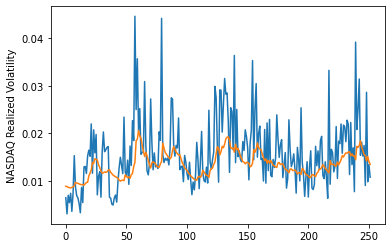

In [48]:
# Best model
plt.plot(range(252), test)
plt.plot(range(252), true_predictions) 
plt.ylabel("NASDAQ Realized Volatility")